In [7]:
import torch
import tiktoken
from torch.nn import functional as F

In [8]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

torch.set_float32_matmul_precision("high")

Using Compute Device: mps


In [9]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape)

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [10]:
from train_gpt2 import GPT, GPTConfig

model = GPT(GPTConfig())
model.to(computeDevice)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50257])
tensor(10.9600, device='mps:0')


In [12]:
from data_loader import DataLoaderLite

torch.mps.empty_cache()
torch.manual_seed(1337)

# B, T = 16, 1024
B, T = 8, 512
# B, T = 4, 256
dataset = DataLoaderLite(B, T)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = dataset.next_batch()
    x, y = x.to(computeDevice), y.to(computeDevice)
    if torch.cuda.is_available():
        with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
            logits, loss = model(x, y)
    else:
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"Step {i}, loss: {loss.item()}")
    losses.append(loss.item())


Loaded 338025 tokens
1 epoch = 82 batches
Step 0, loss: 10.940007209777832
Step 1, loss: 9.519044876098633
Step 2, loss: 8.98745346069336
Step 3, loss: 8.692208290100098
Step 4, loss: 8.378253936767578
Step 5, loss: 8.013583183288574
Step 6, loss: 7.910251617431641
Step 7, loss: 7.703823089599609
Step 8, loss: 7.626391410827637
Step 9, loss: 7.3372802734375
Step 10, loss: 7.353532791137695
Step 11, loss: 7.347437858581543
Step 12, loss: 7.404200077056885
Step 13, loss: 7.298118591308594
Step 14, loss: 6.905921936035156
Step 15, loss: 6.921509742736816
Step 16, loss: 6.722334861755371
Step 17, loss: 6.561412811279297
Step 18, loss: 6.675556659698486
Step 19, loss: 6.682712554931641
Step 20, loss: 6.868740081787109
Step 21, loss: 6.718560218811035
Step 22, loss: 6.658079147338867
Step 23, loss: 6.746021270751953
Step 24, loss: 6.7831902503967285
Step 25, loss: 6.768692970275879
Step 26, loss: 6.594897270202637
Step 27, loss: 6.6491498947143555
Step 28, loss: 6.661286354064941
Step 29, lo

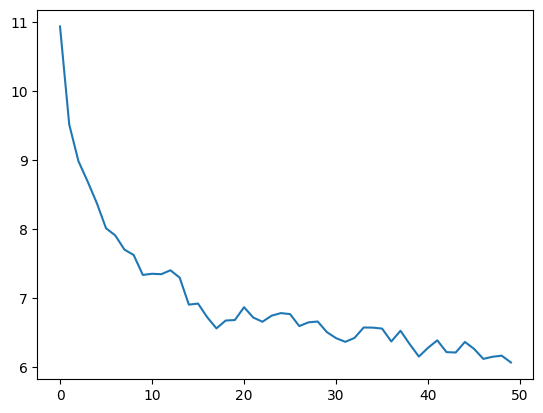

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [14]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [18]:
print(enc.decode(x[:,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

TypeError: argument 'tokens': 'list' object cannot be interpreted as an integer